In [343]:
def extract_cascades_info(vi,tiledir,tiles,nights,petals):
  dataname = tiledir+'/'+tiles[0] + '/deep/zbest-'+str(petals[0])+'-'+str(tiles[0])+'-deep.fits'
  tf = Table.read(dataname,hdu='FIBERMAP')
  tspec = Table.read(dataname,hdu='ZBEST')
  for i in range(1,len(petals)):
      tfn = Table.read(tiledir+'/'+tiles[0] + '/deep/zbest-'+str(petals[i])+'-'+str(tiles[0])+'-deep.fits',hdu='FIBERMAP')
      tf = vstack([tf,tfn])
      tspecn = Table.read(tiledir+'/'+tiles[0] + '/deep/zbest-'+str(petals[i])+'-'+str(tiles[0])+'-deep.fits',hdu='ZBEST')
      tspec = vstack([tspec,tspecn])
            
  EXPID = list(set(tf['EXPID']))[-1] 
  '''This was 0 before but  '''
  tf = tf[tf['EXPID']==EXPID]
  #tf_df = tf['TARGETID','TARGET_RA','TARGET_DEC','FIBER','FLUX_G','FLUX_R','FLUX_Z','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','EBV'].to_pandas()
  tf_df = tf.to_pandas()
  tspec_df = tspec['TARGETID','DELTACHI2','Z','ZWARN','ZERR','CHI2','NPIXELS','SPECTYPE'].to_pandas()
  vi = vi.merge(tspec_df, how='left', on='TARGETID',suffixes=('', '_cas'))
  #print(len(vi.columns))
  return vi

In [344]:
def return_truth_table_name(type_name, tileid):
    truth_table_filename = {'ELG':{'80608':'desi-vi_ELG_tile80608_nightdeep_merged_all_210208.csv','80606':'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv'},
                           'LRG':{'80605':'desi-vi_LRG_tile80605_nightdeep_merged_all_210224.csv','80609':'desi-vi_LRG_tile80609_nightdeep_merged_all_21030.csv'},
                           'BGS':{'80613':'desi-vi_BGS_tile80613_nightdeep_merged_all_210202.csv'},
                           'QSO':{'80605':'desi-vi_QSO_tile80605_nightdeep_merged_all_210223_ADDING_object_info.csv','80607':'desi-vi_QSO_tile80607_nightdeep_merged_all_210214_ADDING_object_info.csv',
                                 '80609':'desi-vi_QSO_tile80609_nightdeep_merged_all_210210_ADDING_object_info.csv'}}
    VI_dir ='/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/'+type_name+'/'
    return VI_dir+truth_table_filename[type_name][tileid]

In [345]:
def return_blanc_and_cascades_info(type_name,tileid):
    
    tiledir   = '/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/'
    file_name = return_truth_table_name(type_name,tileid)
    vi_old = pd.read_csv(file_name, delimiter = ",", engine='python', keep_default_na=False)
    #print(len(vi_old))
    nights = ['20201223']
    petals = ['0','1','2','3','4', '5', '6' ,'7', '8', '9']
    if on_nersc:
        vi = extract_cascades_info(vi_old,tiledir,[tileid],nights,petals)  
    
    vi['delta_delta']=vi['DELTACHI2']-vi['DELTACHI2_cas']
    vi['dz']=abs(vi['Redrock_z']-vi['best_z'])/(1.+vi['best_z'])
    vi['dz_cas']=abs(vi['Z']-vi['best_z'])/(1.+vi['best_z'])
    return vi    

In [346]:
import pandas as pd
import os, sys, glob
import fnmatch
import matplotlib.pyplot as plt
import re
import numpy as np
from astropy.table import Table, join, vstack
import astropy.io.fits as pf
import pandas as pd
plt.rcParams['figure.figsize'] = [12, 8]

In [347]:
type_name_list = ['ELG','ELG','LRG','LRG','BGS','QSO','QSO','QSO']
tileid_list = ['80606','80608','80605','80609','80613','80605','80607','80609']

In [348]:
data_dict = {}
for i_list in range(0,len(type_name_list)):
    data_dict[type_name_list[i_list]+'_'+tileid_list[i_list]]=return_blanc_and_cascades_info(type_name_list[i_list],tileid_list[i_list])

### Deltachi2 distribution Blanc deep vs Cascades deep

Note that Deltachi2 distribution depends on the S/N of the spectra

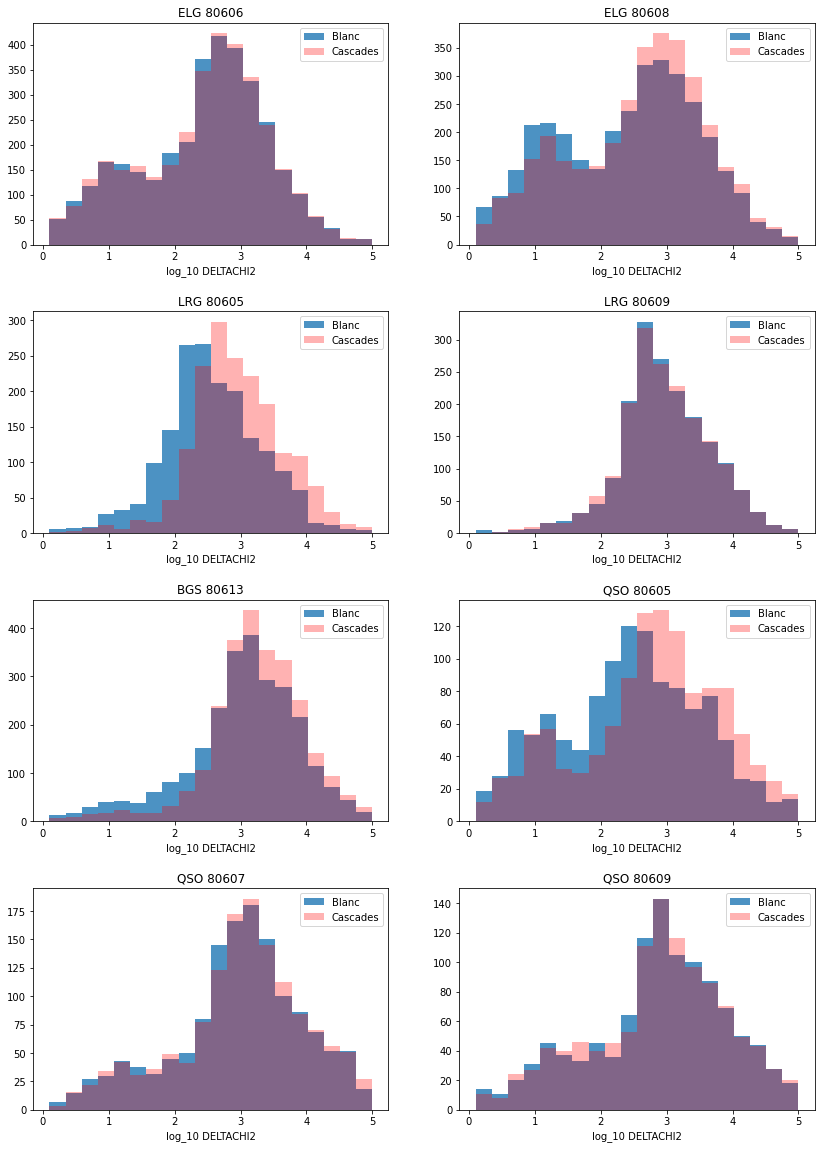

In [331]:
plt.figure(figsize=(14,20))
plt.subplots_adjust(hspace=0.3)
for i_list in range(0,len(type_name_list)):
    plt.subplot(4,2,i_list+1)
    vi = data_dict[type_name_list[i_list]+'_'+tileid_list[i_list]]
    plt.hist(np.log10(vi['DELTACHI2']),range=[0.1,5],bins=20,alpha=0.8,label='Blanc')
    #plt.hist(np.log10(vi['DELTACHI2'][vi['best_quality']>=2.5]),range=[0.1,5],bins=20,alpha=0.8,color='darkblue',label='Blanc quality>=2.5')
    plt.hist(np.log10(vi['DELTACHI2_cas']),range=[0.1,5],bins=20,color='r',alpha=0.3,label='Cascades')
    plt.title(type_name_list[i_list]+' '+tileid_list[i_list])
    plt.legend()
    plt.xlabel('log_10 DELTACHI2')

In [371]:
def calculate_blanc_cascades_good_and_bad(table):
    blanc_cascades_bad = table.loc[(table['best_quality']>=2.5) & (table['dz_cas']>0.0033) & (table['dz']>0.0033)]
    blanc_cascades_good = table.loc[(table['best_quality']>=2.5) & (table['dz_cas']<=0.0033) & (table['dz']<=0.0033)]
    blanc_g_cascades_b = table.loc[(table['best_quality']>=2.5) & (table['dz_cas']>0.0033) & (table['dz']<=0.0033)]
    blanc_b_cascades_g = table.loc[(table['best_quality']>=2.5) & (table['dz_cas']<=0.0033) & (table['dz']>0.0033)]
    total_n = len(table.loc[(table['best_quality']>=2.5)])
    print('Total number:',total_n)
    print('Both Blanc / Cascades:',len(blanc_cascades_good))
    print('Blanc good / Cascades bad:',len(blanc_g_cascades_b))
    print('Blanc bad / Cascades good:',len(blanc_b_cascades_g))
    print('Blanc bad / Cascades bad:',len(blanc_cascades_bad))
    #plt.hist(blanc_cascades_bad['FIBER'],range=(0,5000),bins=20,alpha=0.1)

In [372]:
for i_list in range(0,len(type_name_list)):
    id_name = type_name_list[i_list]+'_'+tileid_list[i_list]
    vi = data_dict[id_name]
    print(id_name)
    calculate_blanc_cascades_good_and_bad(vi)
    print('------------------------')

ELG_80606
Total number: 2588
Both Blanc / Cascades: 2516
Blanc good / Cascades bad: 15
Blanc bad / Cascades good: 15
Blanc bad / Cascades bad: 42
------------------------
ELG_80608
Total number: 2514
Both Blanc / Cascades: 2412
Blanc good / Cascades bad: 26
Blanc bad / Cascades good: 16
Blanc bad / Cascades bad: 60
------------------------
LRG_80605
Total number: 1715
Both Blanc / Cascades: 1670
Blanc good / Cascades bad: 7
Blanc bad / Cascades good: 9
Blanc bad / Cascades bad: 29
------------------------
LRG_80609
Total number: 1747
Both Blanc / Cascades: 1691
Blanc good / Cascades bad: 18
Blanc bad / Cascades good: 13
Blanc bad / Cascades bad: 25
------------------------
BGS_80613
Total number: 2593
Both Blanc / Cascades: 2532
Blanc good / Cascades bad: 5
Blanc bad / Cascades good: 2
Blanc bad / Cascades bad: 54
------------------------
QSO_80605
Total number: 1024
Both Blanc / Cascades: 909
Blanc good / Cascades bad: 8
Blanc bad / Cascades good: 35
Blanc bad / Cascades bad: 72
-----